# Zonally Averaged Overturning Circulation

This notebook shows a simple example of calculation the zonally averaged global meridional overturning circulation - in density space.

**Requirements:** The `conda/analysis3-20.01` (or later) module on the VDI (or your own up-to-date cookbook installation).

**Firstly,** load in the requisite libraries:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm
from dask.distributed import Client

In [2]:
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


<Client: 'tcp://127.0.0.1:34472' processes=4 threads=8, memory=33.67 GB>

**Next,** choose an experiment. This can be any resolution, and can be with or without Gent-McWilliams eddy parameterisation. In this case, we are choosing to limit ourselves to just the last 60 years of the chosen simulation.

In [45]:
expt = '01deg_jra55v13_ryf9091'
session = cc.database.create_session('../cc_database.db')
n_files = -4
# expt = '025deg_jra55_ryf9091_gadi'
# session = cc.database.create_session('../cc_database.db')
# n_files = -5

Load up `ty_trans_rho` - and sum zonally.
Also, if there is a `ty_trans_rho_gm` variable saved, assume that GM is switched on and load that as well. 

In [29]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session,n=n_files)
#psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',chunks={'potrho': None}, n=-10)
psi = psi.sum('grid_xt_ocean')

varlist = cc.querying.get_variables(session, expt)
if varlist['name'].str.contains('ty_trans_rho_gm').any():
    GM = True
    psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session,start_time = start_time)
    psiGM = psiGM.sum('grid_xt_ocean')
else:
    GM = False

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/sqlalchemy/engine/default.py", line 531, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140054583904000 and this is thread id 140053112157952.
Exception closing connection <sqlite3.Connection object at 0x7f60add3ad50>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/sqlalchemy/

Most ACCESS-OM2 simulations save transport with units of kg/s - convert to Sv:

In [30]:
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
if GM:
    psiGM = psiGM / (1e6*rho)

Now, cumulatively sum the transport in the vertical. Note that in MOM5 the `ty_trans_rho_GM` variable is computed differently and **does not** require summing in the vertical. Once the calculation has been laid out, we then load the variable to force the computation to occur.

In [31]:
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
if GM:
    psi_avg = psi_avg + psiGM.mean('time')
    
psi_avg.load()

<xarray.DataArray 'ty_trans_rho' (potrho: 80, grid_yu_ocean: 1080)>
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.4850046e-03, -7.1833078e-03, -9.1215326e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -2.9381295e-03, -7.5614899e-03, -9.7247306e-03],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.1475150e-03, -7.4040610e-03, -9.5726717e-03],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -2.3283064e-10, -4.2685855e-11],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -2.3283064e-10, -4.2685855e-11],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00, -2.3283064e-10, -4.2685855e-11]], dtype=float32)
Coordinates:
  * potrho         (potrho) float64 1.028e+03 1.028e+03 ... 1.038e+03 1.038e+03
  * grid_yu_ocean  (grid_yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.89 90.0

Now we are ready to plot. We usually plot the streamfunction over a reduced range of density levels to highlight the deep ocean contribution...

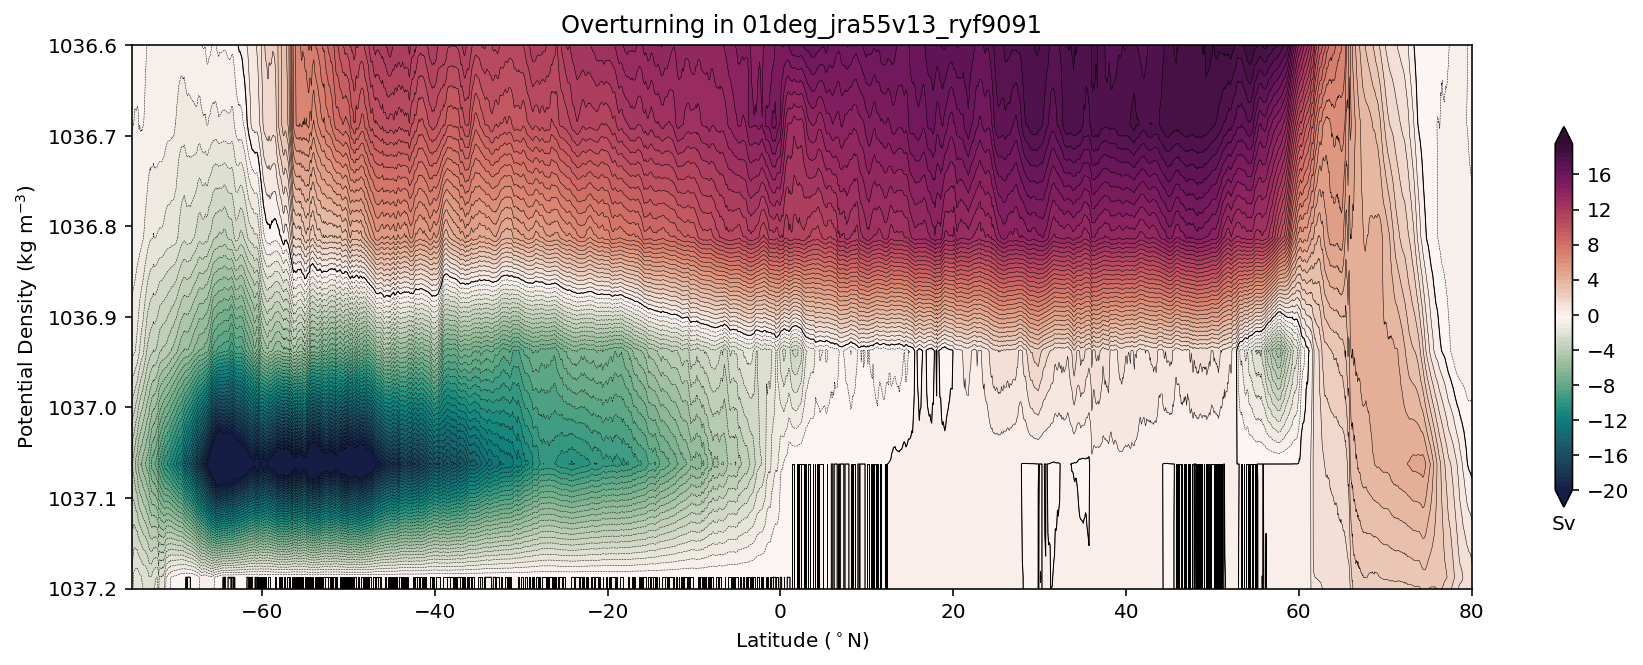

In [27]:
plt.figure(figsize=(15, 5)) 
clev = np.arange(-20,20,0.5)
plt.contourf(psi_avg.grid_yu_ocean,psi_avg.potrho, psi_avg, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.2,1036.6))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);

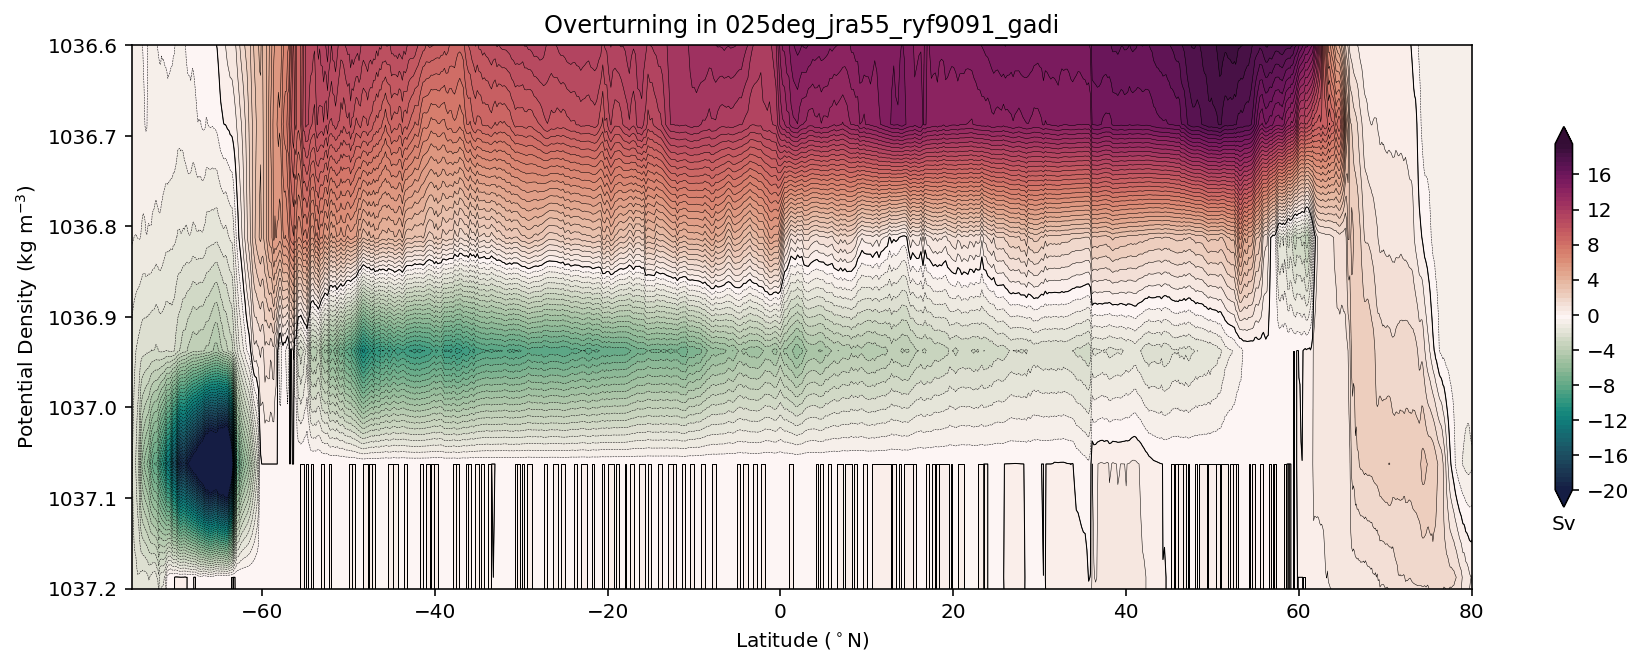

In [32]:
plt.figure(figsize=(15, 5)) 
clev = np.arange(-20,20,0.5)
plt.contourf(psi_avg.grid_yu_ocean,psi_avg.potrho, psi_avg, cmap=cm.cm.curl, levels=clev, extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()

plt.ylim((1037.2,1036.6))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,80])
plt.title('Overturning in %s' % expt);

Alternatively, you may want to stretch your axes to minimise the visual impact of the surface circulation, while showing the full-depth ocean.

**Notes:**
 * We have not included the submesoscale contribution to the meridional transport in these calculations, as it tends to be relatively unimportant for the deep circulation, which we where we are primarily interested.
 * These metrics do not use mathematically correct zonal averaging in the tripole region, north of 65°N.
 
 Below is from the Atlantic and Indo-Pacific only overturning Documented Example

In [46]:
ht = cc.querying.getvar(expt,'ht',session,n=-1) 
land_mask = ~ht.isnull()

## create masks out of the above chunks
south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
atlantic_sector_map = atlantic_sector_map + south_map
atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)

In [47]:
psi = cc.querying.getvar(expt,'ty_trans_rho',session, n=1) ## needs to be the same coordinates as what you want to mask
atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

In [48]:
def compute_basin_psi_rho(expt,session, basin_mask, nbound=None, start_time = None, end_time=None):
    rho = 1025 # mean density of sea-water in kg/m^3
    
    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        print('GM is True')
        psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session, n=nbound,start_time = start_time, end_time=end_time)
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6*rho)
    else:
        GM = False
        print('GM is False')
        
    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound,start_time = start_time, end_time=end_time)      
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load() 
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

In [49]:
%%time
atlantic_psi = compute_basin_psi_rho(expt,session, atlantic_sector_mask, nbound=n_files)

GM is False
CPU times: user 3min 9s, sys: 6.73 s, total: 3min 16s
Wall time: 3min 46s


In [50]:
%%time
indopacific_psi = compute_basin_psi_rho(expt,session, indo_sector_mask, nbound=n_files)

GM is False
CPU times: user 3min 12s, sys: 6.5 s, total: 3min 18s
Wall time: 3min 44s


Text(0.5, 0, 'Sv')

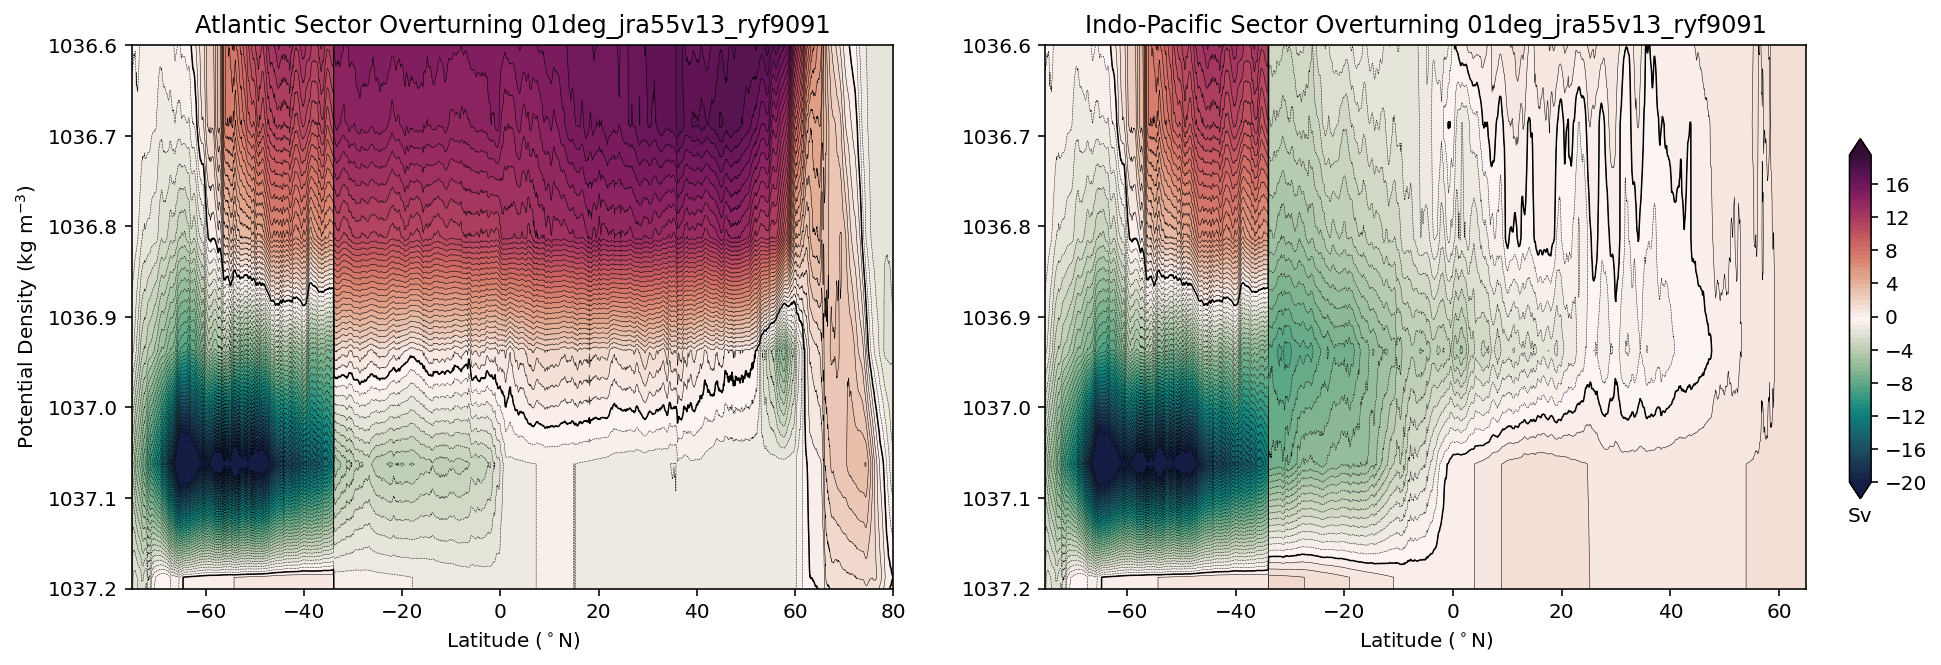

In [54]:
clev=np.arange(-20,20,0.5)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 1  ## A power to set the stretching of the y-axis

fig, ax=plt.subplots(1,2, figsize=(15,5))

## Plotting Atlantic Sector
p1=ax[0].contourf(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[0].contour(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
ax[0].contour(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[0].set_ylim((1037.2,1036.6))
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude ($^\circ$N)')
ax[0].set_xlim([-75,80])
ax[0].set_title('Atlantic Sector Overturning ' + expt);


## Plotting Indo-Pacific Sector
p1=ax[1].contourf(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[1].contour(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
ax[1].contour(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[1].set_ylim((1037.2,1036.6))
ax[1].set_xlabel('Latitude ($^\circ$N)')
ax[1].set_xlim([-75,65])
ax[1].set_title('Indo-Pacific Sector Overturning ' + expt);

# Plot a colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p1,cax = cax,orientation='vertical')
cb.ax.set_xlabel('Sv')

Text(0.5, 0, 'Sv')

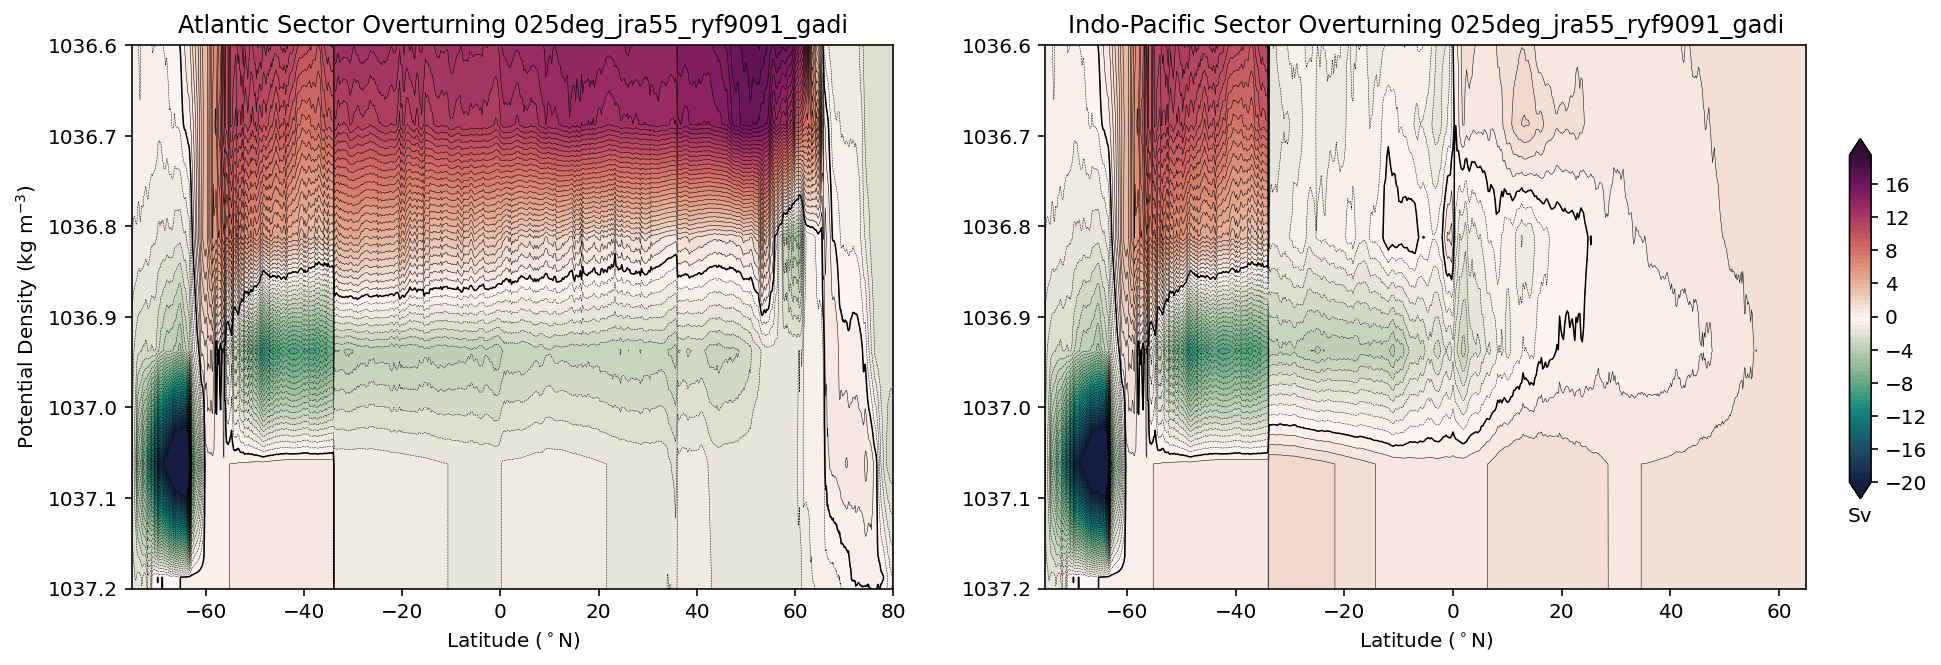

In [44]:
clev=np.arange(-20,20,0.5)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 1  ## A power to set the stretching of the y-axis

fig, ax=plt.subplots(1,2, figsize=(15,5))

## Plotting Atlantic Sector
p1=ax[0].contourf(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[0].contour(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
ax[0].contour(atlantic_psi.grid_yu_ocean,atlantic_psi.potrho, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[0].set_ylim((1037.2,1036.6))
#ax[0].invert_yaxis()
ax[0].set_ylabel('Potential Density (kg m$^{-3}$)')
ax[0].set_xlabel('Latitude ($^\circ$N)')
ax[0].set_xlim([-75,80])
ax[0].set_title('Atlantic Sector Overturning ' + expt);


## Plotting Indo-Pacific Sector
p1=ax[1].contourf(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
ax[1].contour(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
ax[1].contour(indopacific_psi.grid_yu_ocean,indopacific_psi.potrho, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
ax[1].set_ylim((1037.2,1036.6))
#ax[1].invert_yaxis()
ax[1].set_xlabel('Latitude ($^\circ$N)')
ax[1].set_xlim([-75,65])
ax[1].set_title('Indo-Pacific Sector Overturning ' + expt);

# Plot a colorbar
cax = plt.axes([0.92, 0.25, 0.01, 0.5])
cb=plt.colorbar(p1,cax = cax,orientation='vertical')
cb.ax.set_xlabel('Sv')